In [2]:
from google.colab import files
import pandas as pd
import io
import os # To interact with the file system

# 1. Use the files.upload() function
print("Please upload your .zip file(s):")
uploaded = files.upload()

# Get the name of the uploaded zip file
uploaded_zip_filename = list(uploaded.keys())[0]
print(f'User uploaded file "{uploaded_zip_filename}"')

# 2. Unzip the file
# We'll use the !unzip command.
# -o: Overwrite existing files without prompting.
# -d: Specify the destination directory. We'll extract to the current directory '/content/'
#      or you can create a new folder: !mkdir /content/my_data && !unzip {uploaded_zip_filename} -d /content/my_data
print(f"\nUnzipping '{uploaded_zip_filename}'...")
!unzip -o "{uploaded_zip_filename}" -d "/content/" # Extract to current directory

# 3. List files in the current directory to see what was extracted
print("\nFiles in the current directory after unzipping:")
!ls -l /content/

# 4. Identify the CSV file within the unzipped contents
# The unzipped file might be directly in /content/, or in a subfolder.
# Common names for language detection CSVs are 'Language Detection.csv' or 'language_detection.csv'
# If the zip contains a folder (e.g., 'language_dataset/language_detection.csv'), adjust the path.
csv_filename = None
if 'Language Detection.csv' in os.listdir('/content/'):
    csv_filename = 'Language Detection.csv'
elif 'language_detection.csv' in os.listdir('/content/'): # if case of different name
    csv_filename = 'language_detection.csv'
# You might need to check the exact name once you unzip and see the 'ls' output.
# For example, if it unzips into a folder called 'lang_data', then it might be 'lang_data/Language Detection.csv'
# For the Basil B2s dataset, it's usually directly 'Language Detection.csv'

if csv_filename:
    # 5. Load the CSV into a pandas DataFrame
    try:
        df = pd.read_csv(f'/content/{csv_filename}')
        print(f"\nDataFrame '{csv_filename}' loaded successfully!")
        print(df.head())
        print("\nValue counts for each language (if applicable):")
        if 'Language' in df.columns:
            print(df['Language'].value_counts())
        elif 'labels' in df.columns:
            print(df['labels'].value_counts())
        else:
            print("Language column not found. Check your CSV header.")

    except Exception as e:
        print(f"Error loading the CSV file: {e}")
        print("Please ensure the unzipped content contains a valid CSV file.")
else:
    print("Could not find a common CSV file name after unzipping. Please check the 'ls' output above for exact filename and adjust 'csv_filename' variable.")

# Now, 'df' contains your data, and you can proceed with your NLP pipeline
# X = df['Text'] # Or df['text'] depending on your CSV header
# y = df['Language'] # Or df['labels']

Please upload your .zip file(s):


Saving language_detection.zip to language_detection.zip
User uploaded file "language_detection.zip"

Unzipping 'language_detection.zip'...
Archive:  language_detection.zip
  inflating: /content/Language Detection.csv  

Files in the current directory after unzipping:
total 2416
-rw-r--r-- 1 root root 1911016 Feb 10  2021 'Language Detection.csv'
-rw-r--r-- 1 root root  555074 Jun 29 12:49  language_detection.zip
drwxr-xr-x 1 root root    4096 Jun 26 13:35  sample_data

DataFrame 'Language Detection.csv' loaded successfully!
                                                Text Language
0   Nature, in the broadest sense, is the natural...  English
1  "Nature" can refer to the phenomena of the phy...  English
2  The study of nature is a large, if not the onl...  English
3  Although humans are part of nature, human acti...  English
4  [1] The word nature is borrowed from the Old F...  English

Value counts for each language (if applicable):
Language
English       1385
French        1014
Sp

In [4]:
import re
def preprocess_text(text):
    if not isinstance(text, str):
        # Convert non-string types to string, or handle them as per your dataset
        # For this dataset, text column should mostly be strings, but good to be robust.
        text = str(text)

    text = text.lower() # Lowercasing
    # Remove punctuation and numbers, keeping only letters and spaces
    # [^a-z\s] matches any character that is NOT a lowercase letter or a whitespace character.
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip() # Handle extra whitespace and strip leading/trailing spaces
    return text

# --- 5. Apply Preprocessing to the 'Text' Column ---
# Assuming your text column is named 'Text' based on the Kaggle dataset.
# If it's named 'text', 'sentence', etc., adjust accordingly.
text_column_name = 'Text' # Change this if your text column has a different name

if text_column_name in df.columns:
    print(f"\nApplying preprocessing to the '{text_column_name}' column...")
    df['cleaned_text'] = df[text_column_name].apply(preprocess_text)
    print("\nDataFrame after preprocessing (showing 'Text' and 'cleaned_text' columns):")
    print(df[[text_column_name, 'cleaned_text']].head())

    # Now, define X (features) and y (target labels)
    X = df['cleaned_text']
    y = df['Language'] # Assuming 'Language' is your label column

    print("\nPreprocessing complete. 'X' contains the cleaned text, and 'y' contains the language labels.")
    print("Example of X (first 5 cleaned texts):")
    for i, text in enumerate(X.head()):
        print(f"{i}: {text}")
    print("\nExample of y (first 5 labels):")
    print(y.head())

else:
    print(f"Error: Column '{text_column_name}' not found in the DataFrame. Please check your CSV header.")


Applying preprocessing to the 'Text' column...

DataFrame after preprocessing (showing 'Text' and 'cleaned_text' columns):
                                                Text  \
0   Nature, in the broadest sense, is the natural...   
1  "Nature" can refer to the phenomena of the phy...   
2  The study of nature is a large, if not the onl...   
3  Although humans are part of nature, human acti...   
4  [1] The word nature is borrowed from the Old F...   

                                        cleaned_text  
0  nature in the broadest sense is the natural ph...  
1  nature can refer to the phenomena of the physi...  
2  the study of nature is a large if not the only...  
3  although humans are part of nature human activ...  
4  the word nature is borrowed from the old frenc...  

Preprocessing complete. 'X' contains the cleaned text, and 'y' contains the language labels.
Example of X (first 5 cleaned texts):
0: nature in the broadest sense is the natural physical material world or uni

In [6]:
from sklearn.model_selection import train_test_split # New import
from sklearn.feature_extraction.text import TfidfVectorizer # New import
from sklearn.preprocessing import LabelEncoder

In [7]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
language_labels = le.classes_ # Store original language names for later interpretation

print(f"\nOriginal language labels: {language_labels}")
print(f"Encoded labels for first 5: {y_encoded[:5]}")


# --- 6. Split Data into Training and Testing Sets ---
# It's crucial to split your data *before* feature extraction (fitting the vectorizer)
# to prevent "data leakage." The vectorizer should only learn from the training data.
# stratify=y_encoded ensures that the proportion of languages is roughly the same in train and test sets.
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTrain set size: {len(X_train_raw)} samples")
print(f"Test set size: {len(X_test_raw)} samples")


# --- 7. Feature Extraction using TF-IDF Vectorizer ---
print("\nPerforming Feature Extraction using TF-IDF Vectorizer...")
# analyzer='char' specifies character n-grams
# ngram_range=(min_n, max_n) specifies the range of n-gram lengths (e.g., bigrams and trigrams)
# max_features limits the number of features (n-grams) to the top most frequent ones.
#   This helps manage memory and often improves performance by focusing on discriminative features.
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 3), max_features=10000)

# Fit the vectorizer ONLY on the training data to learn the vocabulary
X_train_vectorized = vectorizer.fit_transform(X_train_raw)

# Transform BOTH training and testing data using the *fitted* vectorizer
X_test_vectorized = vectorizer.transform(X_test_raw)

print(f"\nShape of X_train_vectorized: {X_train_vectorized.shape}")
print(f"Shape of X_test_vectorized: {X_test_vectorized.shape}")
print(f"Number of extracted features (n-grams): {len(vectorizer.get_feature_names_out())}")
# print("\nSome example features (n-grams):")
# print(vectorizer.get_feature_names_out()[:50]) # Print first 50 features

print("\nFeature extraction complete. Your data is now in numerical format, ready for model training!")



Original language labels: ['Arabic' 'Danish' 'Dutch' 'English' 'French' 'German' 'Greek' 'Hindi'
 'Italian' 'Kannada' 'Malayalam' 'Portugeese' 'Russian' 'Spanish'
 'Sweedish' 'Tamil' 'Turkish']
Encoded labels for first 5: [3 3 3 3 3]

Train set size: 8269 samples
Test set size: 2068 samples

Performing Feature Extraction using TF-IDF Vectorizer...

Shape of X_train_vectorized: (8269, 8540)
Shape of X_test_vectorized: (2068, 8540)
Number of extracted features (n-grams): 8540

Feature extraction complete. Your data is now in numerical format, ready for model training!


In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB # New import for Naive Bayes
from sklearn.linear_model import LogisticRegression # New import for Logistic Regression
from sklearn.svm import LinearSVC

In [10]:
print("\n--- Training Machine Learning Models ---")

# --- Model 1: Multinomial Naive Bayes ---
print("\nTraining Multinomial Naive Bayes Model...")
nb_model = MultinomialNB()
nb_model.fit(X_train_vectorized, y_train)
print("Multinomial Naive Bayes Model Trained.")

# --- Model 2: Logistic Regression ---
print("\nTraining Logistic Regression Model...")
# max_iter is increased for convergence, solver='liblinear' is good for smaller datasets and L1/L2 regularization
lr_model = LogisticRegression(max_iter=2000, solver='liblinear', random_state=42)
lr_model.fit(X_train_vectorized, y_train)
print("Logistic Regression Model Trained.")

# --- Model 3: Linear Support Vector Classifier (LinearSVC) ---
print("\nTraining Linear Support Vector Classifier (LinearSVC) Model...")
# max_iter for convergence, dual=False is recommended when n_samples > n_features, or for L1 loss
svm_model = LinearSVC(max_iter=2000, random_state=42, dual=True)
svm_model.fit(X_train_vectorized, y_train)
print("LinearSVC Model Trained.")

print("\nAll models have been trained successfully!")


--- Training Machine Learning Models ---

Training Multinomial Naive Bayes Model...
Multinomial Naive Bayes Model Trained.

Training Logistic Regression Model...
Logistic Regression Model Trained.

Training Linear Support Vector Classifier (LinearSVC) Model...
LinearSVC Model Trained.

All models have been trained successfully!


In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # New imports for evaluation
import seaborn as sns # New import for visualization
import matplotlib.pyplot as plt


--- Evaluating Models ---

--- Evaluating Multinomial Naive Bayes ---
Accuracy: 0.6712

Classification Report:
              precision    recall  f1-score   support

      Arabic       0.00      0.00      0.00       107
      Danish       0.98      0.73      0.84        86
       Dutch       0.98      0.91      0.94       109
     English       0.30      1.00      0.47       277
      French       0.93      0.99      0.96       203
      German       0.99      0.94      0.96        94
       Greek       0.00      0.00      0.00        73
       Hindi       0.00      0.00      0.00        12
     Italian       0.98      0.94      0.96       140
     Kannada       0.00      0.00      0.00        74
   Malayalam       0.00      0.00      0.00       119
  Portugeese       0.98      0.97      0.97       148
     Russian       0.50      0.01      0.03       138
     Spanish       0.97      0.97      0.97       164
    Sweedish       0.89      0.98      0.93       135
       Tamil       0.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


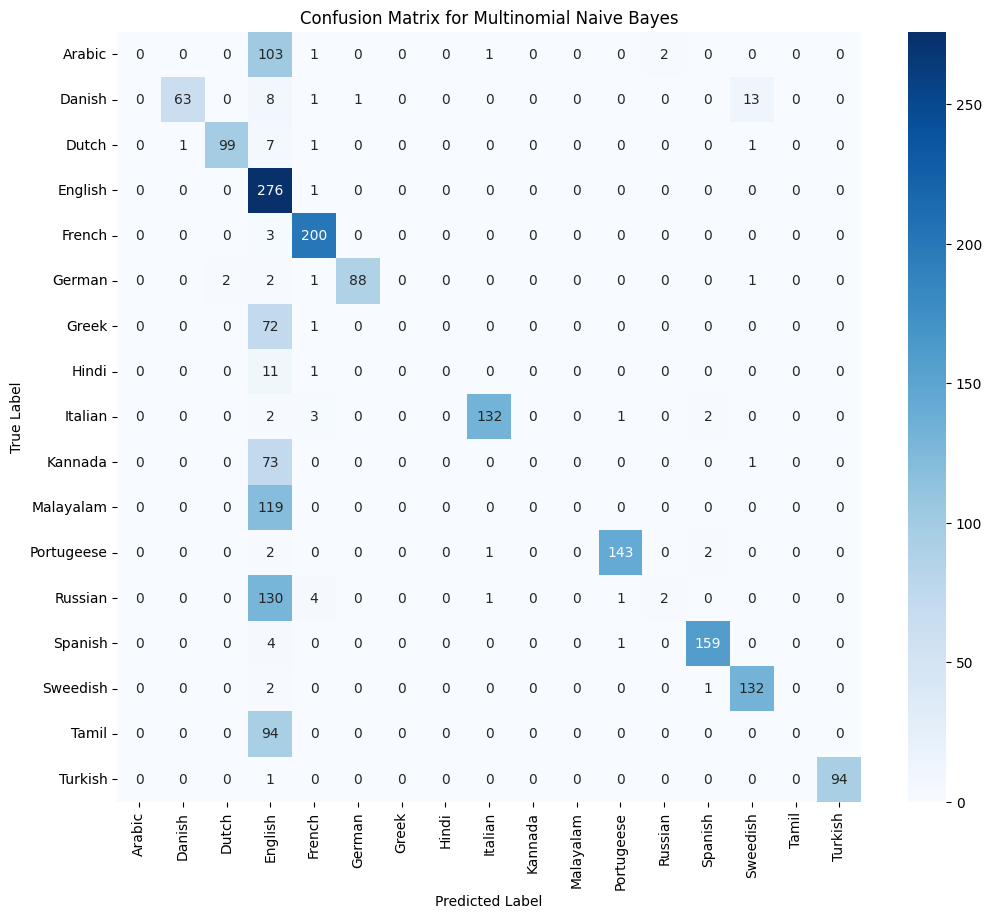


--- Evaluating Logistic Regression ---
Accuracy: 0.7437

Classification Report:
              precision    recall  f1-score   support

      Arabic       0.00      0.00      0.00       107
      Danish       0.99      0.94      0.96        86
       Dutch       0.97      0.94      0.96       109
     English       0.96      0.99      0.97       277
      French       0.99      0.98      0.99       203
      German       0.97      0.98      0.97        94
       Greek       0.67      0.03      0.05        73
       Hindi       0.00      0.00      0.00        12
     Italian       0.96      0.96      0.96       140
     Kannada       0.00      0.00      0.00        74
   Malayalam       0.00      0.00      0.00       119
  Portugeese       0.98      0.96      0.97       148
     Russian       0.21      0.96      0.35       138
     Spanish       0.98      0.96      0.97       164
    Sweedish       0.99      0.98      0.98       135
       Tamil       0.00      0.00      0.00        94


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


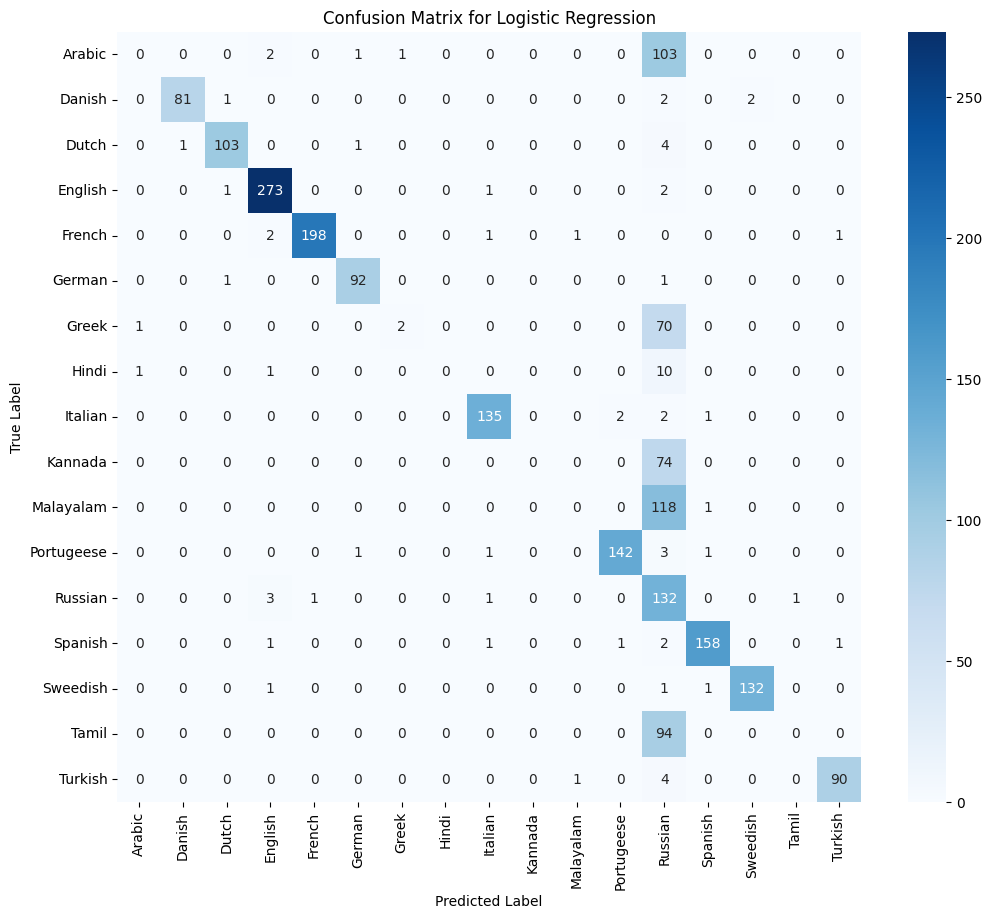


--- Evaluating Linear SVM ---
Accuracy: 0.7519

Classification Report:
              precision    recall  f1-score   support

      Arabic       0.25      0.01      0.02       107
      Danish       0.96      0.95      0.96        86
       Dutch       0.98      0.96      0.97       109
     English       0.97      0.99      0.98       277
      French       0.98      0.98      0.98       203
      German       0.99      1.00      0.99        94
       Greek       0.50      0.04      0.08        73
       Hindi       0.00      0.00      0.00        12
     Italian       0.96      0.97      0.96       140
     Kannada       0.00      0.00      0.00        74
   Malayalam       0.25      0.01      0.02       119
  Portugeese       0.97      0.97      0.97       148
     Russian       0.22      0.93      0.35       138
     Spanish       0.98      0.98      0.98       164
    Sweedish       0.99      0.99      0.99       135
       Tamil       0.00      0.00      0.00        94
     Turk

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


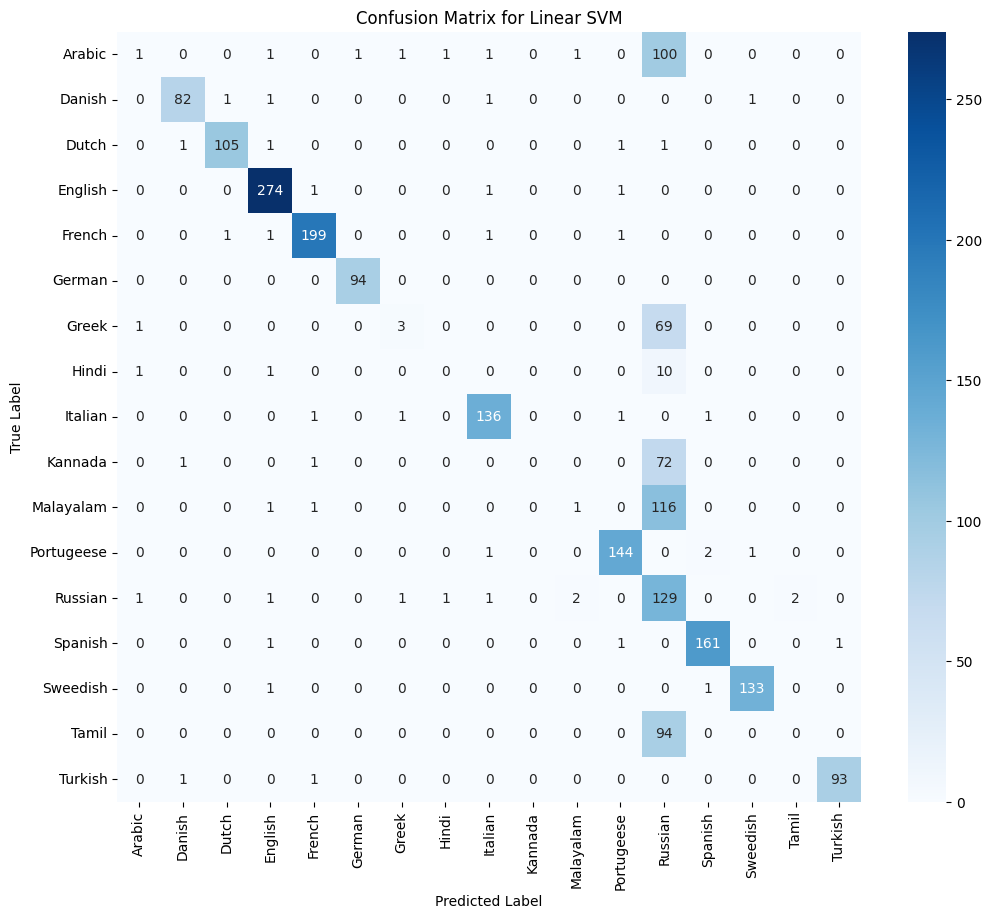


Model evaluation complete. Review the accuracy, classification reports, and confusion matrices above.


In [12]:
# --- 9. Model Evaluation ---
print("\n--- Evaluating Models ---")

models = {
    "Multinomial Naive Bayes": nb_model,
    "Logistic Regression": lr_model,
    "Linear SVM": svm_model
}

for model_name, model in models.items():
    print(f"\n--- Evaluating {model_name} ---")

    # Make predictions on the test set
    y_pred = model.predict(X_test_vectorized)

    # Decode predictions back to original language names for readability
    y_test_labels = le.inverse_transform(y_test)
    y_pred_labels = le.inverse_transform(y_pred)

    # Overall Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Classification Report
    # target_names is important to show actual language names instead of encoded numbers
    print("\nClassification Report:")
    print(classification_report(y_test_labels, y_pred_labels, target_names=language_labels))

    # Confusion Matrix
    cm = confusion_matrix(y_test_labels, y_pred_labels, labels=language_labels)
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d', # 'd' for integer format
        cmap='Blues',
        xticklabels=language_labels,
        yticklabels=language_labels
    )
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

print("\nModel evaluation complete. Review the accuracy, classification reports, and confusion matrices above.")

In [14]:
import joblib
# --- 10. Building a Prediction Function (Inference) ---
print("\n--- Building Prediction Function ---")

def predict_language(text_input, model, vectorizer, label_encoder, preprocess_func):
    """
    Predicts the language of a given text string.

    Args:
        text_input (str): The input text whose language needs to be predicted.
        model (sklearn classifier): The trained machine learning model.
        vectorizer (sklearn TfidfVectorizer or CountVectorizer): The fitted vectorizer.
        label_encoder (sklearn LabelEncoder): The fitted label encoder to decode predictions.
        preprocess_func (function): The preprocessing function used during training.

    Returns:
        str: The predicted language.
    """
    # 1. Preprocess the input text using the SAME function as training
    cleaned_text = preprocess_func(text_input)

    # 2. Vectorize the cleaned text using the *fitted* vectorizer
    #    Note: vectorizer.transform expects an iterable (list) of strings
    vectorized_text = vectorizer.transform([cleaned_text])

    # 3. Make the prediction (outputs a numerical label)
    predicted_label_numeric = model.predict(vectorized_text)[0]

    # 4. Decode the numerical label back to the original language name
    predicted_language = label_encoder.inverse_transform([predicted_label_numeric])[0]

    return predicted_language

# Test the prediction function with some new sentences
print("\nTesting the prediction function:")
test_sentences = [
    "Hello, how are you today?",                  # English
    "¿Qué tal estás?",                            # Spanish
    "Ceci est un exemple de texte en français.",  # French
    "A quick brown fox.",                         # English
    "Comment ça va?",                             # French
    "Este es un día soleado.",                    # Spanish
    "Das ist ein deutscher Satz.",                # German (if your dataset included German)
    "I am learning NLP."                          # English
]

for sentence in test_sentences:
    # Ensure the 'nb_model' is the one you want to use for predictions
    predicted = predict_language(sentence, nb_model, vectorizer, le, preprocess_text)
    print(f"Text: '{sentence}' -> Predicted: {predicted}")


# --- 11. Saving and Loading the Trained Model & Vectorizer ---
print("\n--- Saving Trained Model and Vectorizer ---")

# Define filenames for saving
model_filename = 'language_detector_model.joblib'
vectorizer_filename = 'tfidf_vectorizer.joblib'
label_encoder_filename = 'label_encoder.joblib'

# Save the trained model
joblib.dump(nb_model, model_filename)
print(f"Model saved as '{model_filename}'")

# Save the fitted vectorizer
joblib.dump(vectorizer, vectorizer_filename)
print(f"Vectorizer saved as '{vectorizer_filename}'")

# Save the fitted label encoder
joblib.dump(le, label_encoder_filename)
print(f"Label Encoder saved as '{label_encoder_filename}'")

print("\nSaved artifacts can be downloaded from the Colab file explorer (left sidebar).")

# --- Optional: Demonstrate Loading the Saved Model and Making a Prediction ---
print("\n--- Demonstrating Loading Saved Model and Prediction ---")
print("Loading model, vectorizer, and label encoder...")

loaded_model = joblib.load(model_filename)
loaded_vectorizer = joblib.load(vectorizer_filename)
loaded_label_encoder = joblib.load(label_encoder_filename)

print("Artifacts loaded successfully!")

# Use the loaded components to make a prediction
test_sentence_loaded = "Where did you go?"
predicted_loaded = predict_language(
    test_sentence_loaded,
    loaded_model,
    loaded_vectorizer,
    loaded_label_encoder,
    preprocess_text
)
print(f"Text (from loaded model): '{test_sentence_loaded}' -> Predicted: {predicted_loaded}")



--- Building Prediction Function ---

Testing the prediction function:
Text: 'Hello, how are you today?' -> Predicted: English
Text: '¿Qué tal estás?' -> Predicted: Spanish
Text: 'Ceci est un exemple de texte en français.' -> Predicted: French
Text: 'A quick brown fox.' -> Predicted: English
Text: 'Comment ça va?' -> Predicted: French
Text: 'Este es un día soleado.' -> Predicted: Spanish
Text: 'Das ist ein deutscher Satz.' -> Predicted: German
Text: 'I am learning NLP.' -> Predicted: English

--- Saving Trained Model and Vectorizer ---
Model saved as 'language_detector_model.joblib'
Vectorizer saved as 'tfidf_vectorizer.joblib'
Label Encoder saved as 'label_encoder.joblib'

Saved artifacts can be downloaded from the Colab file explorer (left sidebar).

--- Demonstrating Loading Saved Model and Prediction ---
Loading model, vectorizer, and label encoder...
Artifacts loaded successfully!
Text (from loaded model): 'Where did you go?' -> Predicted: English
